本代码任务：音频转文字（将音频的频谱图输入以CTC作为损失函数的DFCNN中，输出音频对应的文字）

第一部分：使用案例音频进行音频转频谱图的演示（语音预处理部分）

第二部分：正式使用音频数据集进行建模

In [1]:
#相关包
from scipy.io import wavfile #音频数据读取
from scipy.fftpack import fft #音频数据处理-傅里叶变换
import os
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle #数据生成器中的打乱

## 一、音频数据读取+特征提取（演示）

基本概念：

采样率：
即取样频率, 指每秒钟取得声音样本的次数。采样频率越高,声音的质量也就越好,声音的还原也就越真实，但同时它占的资源比较多。由于人耳的分辨率很有限,太高的频率并不能分辨出来。

采样位数/量化精度：
即采样值或取样值（就是将采样样本幅度量化）。它是用来衡量声音波动变化的一个参数，也可以说是声卡的分辨率。它的数值越大，分辨率也就越高，所发出声音的能力越强。
每个采样数据记录的是振幅, 采样精度取决于采样位数的大小:
1 字节(也就是8bit) 只能记录 256 个数, 也就是只能将振幅划分成 256 个等级;
2 字节(也就是16bit) 可以细到 65536 个数, 这已是 CD 标准了;
4 字节(也就是32bit) 能把振幅细分到 4294967296 个等级, 实在是没必要了.

采样率和采样点数：
采样率是每秒取得声音样本的次数（波形中相隔两点时间的倒数），采样点数是一次返回的数据量包含的点数（这里的点对应着一个波形中的一个数据）

汉明窗：
一个函数，在某一区间非零，其余区间为0 => 使得每次仅对一个区间内的音频数据进行处理 => 达到分段处理的效果

参考资料：
https://blog.csdn.net/sinat_28442665/article/details/86179002
https://vimsky.com/examples/usage/python-scipy.io.wavfile.read.html
https://www.jianshu.com/p/b195e685fe09
https://www.cnblogs.com/lxy2017/p/4049124.html
https://blog.csdn.net/gxiaoyaya/article/details/73555195
https://blog.csdn.net/lv_xinmy/article/details/8587865
https://zhuanlan.zhihu.com/p/54303745
https://blog.csdn.net/rookie_wei/article/details/84527839

### 1.读取数据

In [2]:
#读入音频数据
filepath = '/mnt/thchs30/train/A13_21.wav'
sample_rate,wavdata = wavfile.read(filepath) #返回采样率(int)和（波形）数据（numpy数组，可能为int/float，取决于wav格式）

In [3]:
#查看音频数据维度
wavdata.shape

(152320,)

In [4]:
#查看音频的基本信息（采样率、音频长度等）

#采样率
print('采样率:%d'%sample_rate)

#音频长度，以s为单位
length = wavdata.shape[0] / sample_rate
print('长度：%f'%length)

#查看数据基本形态
print(wavdata)

采样率:16000
长度：9.520000
[-219 -203 -197 ... -132 -123 -115]


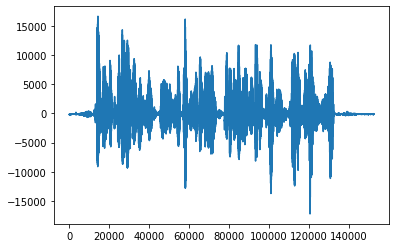

In [5]:
#绘制波形图
plt.plot(wavdata)
plt.show()

### 2.帧切割

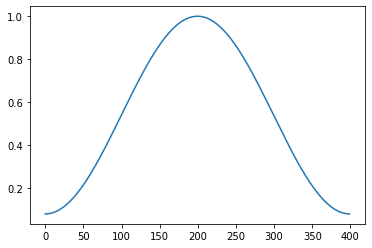

In [6]:
#构建汉明窗函数w
#（在这里汉明窗长度取为400，同时也是后续傅里叶变换的长度，也即频谱图的长度，但是考虑到长宽成反比，所以长度的选择会影响到语音识别的效果）
x = np.linspace(0, 400 - 1, 400, dtype = np.int64)
w = 0.54 - 0.46 * np.cos(2 * np.pi * (x) / (400 - 1))

#可视化展现汉明窗函数，在后面会将w乘以音频数据wavdata达到加窗效果
plt.plot(w)
plt.show()

In [7]:
#对数据分帧，设置帧长为25ms，后续的帧移为10ms
#（因为下面仅以第一帧为案例转频谱图所以没有用到帧移，但后面对整条语音的处理需要用到帧移）
time_window = 25
window_length = sample_rate / 1000 * time_window
print(window_length) #窗长，也即后续频谱图的长度

400.0


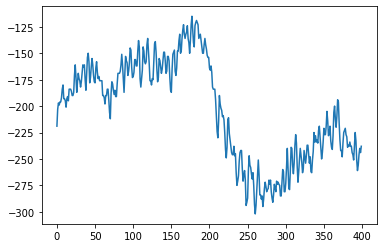

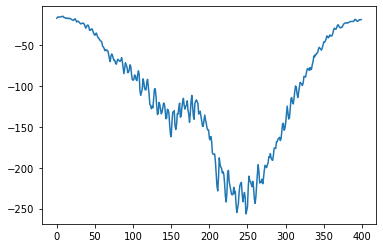

In [8]:
#分帧加窗（以第一帧为例，下面的fft处理同理）
#分帧
p_begin = 0
p_end = int(p_begin + window_length)
frame = wavdata[p_begin : p_end]
plt.plot(frame)
plt.show()
#加窗（也即乘以汉明窗函数）
frame = frame * w
plt.plot(frame)
plt.show()

### 3.傅里叶变换

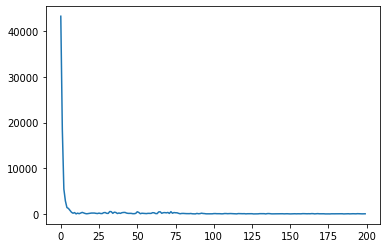

In [9]:
#傅里叶变换
frame_fft = np.abs(fft(frame))[:200]
#可视化呈现
plt.plot(frame_fft)
plt.show()

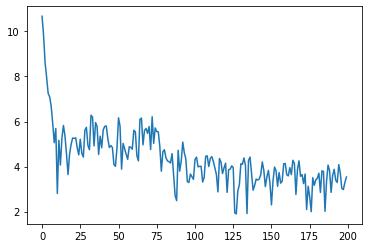

In [10]:
#对纵轴求对数即得到分贝db
frame_log = np.log(frame_fft)
#可视化展现
plt.plot(frame_log)
plt.show()

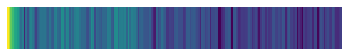

In [11]:
#转为时频图
#该数据是第一帧数据，实际上是一维数组，可视化展现不方便呈现，故循环重复使得纵轴变宽以方便查看，但后续对整条音频处理不必如此操作
first_fbank = np.zeros((25, 200), dtype=np.float64)
for i in range(25):
    first_fbank[i] = frame_log[0:200]
       
plt.imshow(first_fbank, origin='lower')
plt.axis('off')
plt.show()

### 4.获取音频文件的时频图

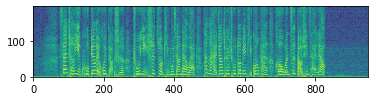

In [12]:
#由于上面是为了演示每一步的操作，所以拆分出来。后续为了操作方便，将上面的操作合并为一个函数。
def compute_fbank(file):
    #汉明窗函数
    x = np.linspace(0, 400 - 1, 400, dtype=np.int64)
    w = 0.54 - 0.46 * np.cos(2 * np.pi * (x) / (400 - 1))
    
    #读入数据
    sample_rate,wavdata = wavfile.read(file)
    time_window = 25
    window_length = sample_rate / 1000 * time_window
    
    #分帧
    wav_arr = np.array(wavdata)
    wav_length = len(wavdata)
    range0_end = int(len(wavdata) / sample_rate * 1000 - time_window) // 10
    
    #按帧加窗、fft处理存入新数组
    data_input = np.zeros((range0_end, 200), dtype=np.float64)
    data_line = np.zeros((1, 400), dtype=np.float64)
    for i in range(0, range0_end):
        p_start = i * 160
        p_end = p_start + 400
        data_line = wav_arr[p_start:p_end]
        data_line = data_line * w
        data_line = np.abs(fft(data_line))
        data_input[i] = data_line[0:200]
    data_input = np.log(data_input + 1)
    return data_input

#compute_fbank函数也即对前三个步骤的分装并运用于所有帧
#可视化展示时频图（不仅仅是单帧，还涉及帧移，是完整音频的时频图）
test_fbank = compute_fbank(filepath)
plt.imshow(test_fbank.T, origin='lower')
plt.show()

## 二、神经网络构建（正式建模）

### 1.读取数据+数据处理

#### 1-1.读取数据：获取训练音频文件及标注文件列表

In [2]:
#本部分自定义函数：
#从文件夹中读取音频数据、标签的文件名，存入数组（返回的数组中存放的是文件名）
def source_get(source_file):
    train_file = source_file + '/train'
    label_lst = []
    wav_lst = []
    for root, dirs, files in os.walk(train_file):
        for file in files:
            #读取音频文件名、构造标签文件名，存入两个文件名数组
            if file.endswith('.wav') or file.endswith('.WAV'):
                wav_file = os.sep.join([root, file])
                label_file = source_file + '/data/' + file +'.trn'
                wav_lst.append(wav_file)
                label_lst.append(label_file)

    return label_lst, wav_lst


#输入路径，读取音频文件对应的label（返回的数组中存放的是单个音频的标签数据）
def read_label(label_file):
    with open(label_file, 'r', encoding='utf8') as f:
        data = f.readlines()
        return data[0] #该数据集标签数据第一行为汉字，第二行为拼音，此处只需要汉字

#输入路径数组，读取所有label（返回的数组中存放的是所有音频的标签数据）
def gen_label_data(label_lst):
    label_data = []
    for label_file in label_lst:
        hanzi = read_label(label_file)
        hanzi = hanzi.replace(' ', '') #取消汉字间隔
        label_data.append(hanzi.strip('\n')) #取消换行符
    return label_data

In [14]:
#读取数据（thchs30数据）
source_file = '/mnt/thchs30'
label_lst, wav_lst = source_get(source_file)

#查看前十条文件名
print(label_lst[:10])
print(wav_lst[:10])

['/mnt/thchs30/data/C7_666.wav.trn', '/mnt/thchs30/data/A7_80.wav.trn', '/mnt/thchs30/data/B8_433.wav.trn', '/mnt/thchs30/data/B32_469.wav.trn', '/mnt/thchs30/data/B15_493.wav.trn', '/mnt/thchs30/data/A19_74.wav.trn', '/mnt/thchs30/data/A14_248.wav.trn', '/mnt/thchs30/data/B33_429.wav.trn', '/mnt/thchs30/data/C19_602.wav.trn', '/mnt/thchs30/data/A4_93.wav.trn']
['/mnt/thchs30/train/C7_666.wav', '/mnt/thchs30/train/A7_80.wav', '/mnt/thchs30/train/B8_433.wav', '/mnt/thchs30/train/B32_469.wav', '/mnt/thchs30/train/B15_493.wav', '/mnt/thchs30/train/A19_74.wav', '/mnt/thchs30/train/A14_248.wav', '/mnt/thchs30/train/B33_429.wav', '/mnt/thchs30/train/C19_602.wav', '/mnt/thchs30/train/A4_93.wav']


In [16]:
#测试：读取第一个文件内容
print(read_label(label_lst[0]))

#获取所有label数据
label_data = gen_label_data(label_lst)
print(len(label_data))

著 名演员 有成 方圆 牟 炫 甫 远征 张强 陈 俊华 訾 莎莉 欧阳 滨 林文 增 周维 等

10000


#### 1-2.数据的处理：label数据转数字（建立词汇表字典）

In [3]:
#本部分自定义函数：
#提取本数据集label中所有汉字（不重复）形成词汇表vacab
def mk_vocab(label_data):
    vocab = []
    for line in label_data:
        for hanzi in line:
            if hanzi not in vocab:
                vocab.append(hanzi)
    vocab.append('_')
    return vocab

# 将vocab中的汉字转数字id
def word2id(line, vocab):
    return [vocab.index(hanzi) for hanzi in line]

In [18]:
vocab = mk_vocab(label_data)
print(vocab[:10]) #打印词汇表中部分内容
print(len(vocab)) #打印词汇表长度

['著', '名', '演', '员', '有', '成', '方', '圆', '牟', '炫']
2666


In [19]:
#测试：以第一个音频数据为例
label_id = word2id(label_data[0], vocab)
print(label_data[0]) #打印第一个音频数据的label（以汉字形式）
print(label_id) #打印第一个音频数据的label（以id形式）

著名演员有成方圆牟炫甫远征张强陈俊华訾莎莉欧阳滨林文增周维等
[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


#### 1-3.数据的处理：音频数据转时频图

In [4]:
#本部分自定义函数（同演示部分的函数）
def compute_fbank(file):
    x = np.linspace(0, 400 - 1, 400, dtype=np.int64)
    w = 0.54 - 0.46 * np.cos(2 * np.pi * (x) / (400 - 1))
    
    sample_rate,wavdata = wavfile.read(file)
    
    time_window = 25
    window_length = sample_rate / 1000 * time_window
    
    wav_arr = np.array(wavdata)
    wav_length = len(wavdata)
    range0_end = int(len(wavdata) / sample_rate * 1000 - time_window) // 10
    
    data_input = np.zeros((range0_end, 200), dtype=np.float64)
    data_line = np.zeros((1, 400), dtype=np.float64)
    for i in range(0, range0_end):
        p_start = i * 160
        p_end = p_start + 400
        data_line = wav_arr[p_start:p_end]
        data_line = data_line * w
        data_line = np.abs(fft(data_line))
        data_input[i] = data_line[0:200]
    data_input = np.log(data_input + 1)
    return data_input

(1240, 200)


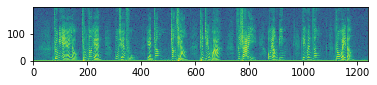

In [21]:
# 测试
# 输入第一个音频的时频图
fbank = compute_fbank(wav_lst[0])
# 由于声学模型网络结构原因（3个maxpooling层），我们的音频数据的每个维度需要能够被8整除。
fbank = fbank[:fbank.shape[0] // 8 * 8, :]
print(fbank.shape)

plt.imshow(fbank.T, origin='lower')
plt.show()

#### 1-4.数据生成器：实现shuffle+batch吞吐数据

In [5]:
#本部分自定义函数：
#按batch获取数据（时频图+label）：
#带有yield的函数被称为生成器generator，返回一个迭代对象，通过next()方法得到一个迭代值
def get_batch(batch_size, shuffle_list, wav_list, label_data, vocab):
    #对每一个batch建立波形数据list、标签list
    for i in range(len(wav_list) // batch_size):
        wav_data_lst = []
        label_data_lst = []
        
        #从整个训练数据中截取该batch
        begin = i * batch_size
        end = begin + batch_size
        sub_list = shuffle_list[begin:end]
        
        for index in sub_list:
            #获得时频图
            fbank = compute_fbank(wav_list[index])
            fbank = fbank[:fbank.shape[0] // 8 * 8, :]
            
            #获得label（以字典中对应的数字来表示）
            label = word2id(label_data[index], vocab)
            
            wav_data_lst.append(fbank)
            label_data_lst.append(label)
            
        #每次返回一个batch的时频图和label
        yield wav_data_lst, label_data_lst

        
#时频图的补零处理：每一个batch的数据构成一个tensorflow，所以长度要统一，需要补零处理
def wav_padding(wav_data_lst):
    
    wav_lens = [len(data) for data in wav_data_lst] # 时频图长度
    wav_max_len = max(wav_lens) # 时频图长度最大值
    
    #新的时频图矩阵（四维：前两维为图片个数、音频长度，后两维代表了每帧的时频图）
    new_wav_data_lst = np.zeros((len(wav_data_lst), wav_max_len, 200, 1))
    for i in range(len(wav_data_lst)):
        new_wav_data_lst[i, :wav_data_lst[i].shape[0], :, 0] = wav_data_lst[i]
    
    #后续输入ctc的音频长度（由于ctc处理之前经过神经网络处理，长度缩短为8倍）
    wav_lens = np.array([leng // 8 for leng in wav_lens])
    
    return new_wav_data_lst, wav_lens


#label的补零处理：同上一个函数
def label_padding(label_data_lst):
    
    label_lens = np.array([len(label) for label in label_data_lst])
    max_label_len = max(label_lens)
    
    new_label_data_lst = np.zeros((len(label_data_lst), max_label_len))
    for i in range(len(label_data_lst)):
        new_label_data_lst[i][:len(label_data_lst[i])] = label_data_lst[i]
        
    return new_label_data_lst, label_lens


#用于训练格式的数据生成器
def data_generator(batch_size, shuffle_list, wav_lst, label_data, vocab):
    for i in range(len(wav_lst) // batch_size):
        wav_data_lst = []
        label_data_lst = []
        
        #获得一个batch的数据
        begin = i * batch_size
        end = begin + batch_size
        sub_list = shuffle_list[begin:end]
        
        #提取该batch数据的频谱图和标签
        for index in sub_list:
            #频谱图
            fbank = compute_fbank(wav_lst[index])
            pad_fbank = np.zeros((fbank.shape[0] // 8 * 8 + 8, fbank.shape[1]))
            pad_fbank[:fbank.shape[0], :] = fbank
            #标签
            label = word2id(label_data[index], vocab)
            #存入数组
            wav_data_lst.append(pad_fbank)
            label_data_lst.append(label)
            
        #补零处理调整数组格式
        pad_wav_data, input_length = wav_padding(wav_data_lst)
        pad_label_data, label_length = label_padding(label_data_lst)
        
        #设置ctc的输入和输出
        inputs = {'the_inputs': pad_wav_data,
                  'the_labels': pad_label_data,
                  'input_length': input_length,
                  'label_length': label_length,
                  }
        outputs = {'ctc': np.zeros(pad_wav_data.shape[0], )}
        
        yield inputs, outputs

In [23]:
##### 测试：以第一个batch为例 #####
#设置batch_size和batch_num
total_nums = 1000
batch_size = 4
batch_num = total_nums // batch_size

#打乱用于训练的数据顺序
shuffle_list = [i for i in range(10000)]
shuffle(shuffle_list)

#实例化数据吞吐器
batch = get_batch(batch_size, shuffle_list, wav_lst, label_data, vocab)

In [24]:
wav_data_lst, label_data_lst = next(batch)

print('\n时频图尺寸：')
for wav_data in wav_data_lst:
    print(wav_data.shape)

print('\n转文字后的字数：')
for label_data in label_data_lst:
    print(len(label_data))

print('\n音频长度：')
lens = [len(wav) for wav in wav_data_lst]
print('时长',lens) # 时长
print('最大时长',max(lens)) # 时长最大值

print('\n音频数据填充处理：')
pad_wav_data_lst, wav_lens = wav_padding(wav_data_lst)
print(pad_wav_data_lst.shape)
print(wav_lens)

print('\nlabel数据填充处理：')
pad_label_data_lst, label_lens = label_padding(label_data_lst)
print(pad_label_data_lst.shape)
print(label_lens)


时频图尺寸：
(952, 200)
(896, 200)
(1072, 200)
(720, 200)

转文字后的字数：
33
31
33
34

音频长度：
时长 [952, 896, 1072, 720]
最大时长 1072

音频数据填充处理：
(4, 1072, 200, 1)
[119 112 134  90]

label数据填充处理：
(4, 34)
[33 31 33 34]


### 2.网络构建

In [6]:
#需要的各种层、优化函数等
import keras
from keras.layers import Input, Conv2D, BatchNormalization, MaxPooling2D, Reshape, Dense, Lambda
from keras.optimizers import Adam
from keras import backend as K
from keras.models import Model
from keras.utils import multi_gpu_model

Using TensorFlow backend.


#### 2-1.网络搭建

In [12]:
def dense(units, activation="relu"):
    return Dense(units, activation='relu', use_bias=True,
                 kernel_initializer='he_normal')


#构造DFCNN中的卷积池化层函数（两个卷积+BN）
def cnn_cell(size, x, pool=True):
    x = Conv2D(size, (3, 3), use_bias=True, activation='relu',padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=-1)(x)
    x = Conv2D(size, (3, 3), use_bias=True, activation='relu',padding='same', kernel_initializer='he_normal')(x)
    x = BatchNormalization(axis=-1)(x)
    if pool:
        x = MaxPooling2D(pool_size=(2, 2), strides=None, padding="valid")(x)
    return x

#使用CTC损失函数（keras内置）
def ctc_lambda(args):
    labels, y_pred, input_length, label_length = args
    y_pred = y_pred[:, :, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

#DFCNN模型
class Amodel():
    #给出必要的参数并对模型初始化
    def __init__(self, vocab_size):
        super(Amodel, self).__init__()
        self.vocab_size = vocab_size
        self._model_init()
        self._ctc_init()
        self.opt_init()

    #DFCNN构建（四个卷积池化层、两个全连接层）
    def _model_init(self):
        self.inputs = Input(name='the_inputs', shape=(None, 200, 1))
        self.h1 = cnn_cell(32, self.inputs)
        self.h2 = cnn_cell(64, self.h1)
        self.h3 = cnn_cell(128, self.h2)
        self.h4 = cnn_cell(128, self.h3, pool=False)
        self.h6 = Reshape((-1, 3200))(self.h4)
        self.h7 = Dense(256, activation='relu', use_bias=True, kernel_initializer='he_normal')(self.h6)
        self.outputs = Dense(self.vocab_size, activation='softmax', use_bias=True, kernel_initializer='he_normal')(self.h7)
        self.model = Model(inputs=self.inputs, outputs=self.outputs)
    
    #CTC构建（输入输出为前文padding函数的返回值）
    def _ctc_init(self):
        self.labels = Input(name='the_labels', shape=[None], dtype='float32')
        self.input_length = Input(name='input_length', shape=[1], dtype='int64')
        self.label_length = Input(name='label_length', shape=[1], dtype='int64')
        self.loss_out = Lambda(ctc_lambda, output_shape=(1,), name='ctc') \
            ([self.labels, self.outputs, self.input_length, self.label_length])
        self.ctc_model = Model(inputs=[self.labels, self.inputs,
                                       self.input_length, self.label_length], outputs=self.loss_out)
        
    #优化函数构建（使用adam优化器）
    def opt_init(self):
        opt = Adam(lr=0.0008, beta_1=0.9, beta_2=0.999, decay=0.01, epsilon=10e-8)
        self.ctc_model.compile(loss={'ctc': lambda y_true, output: output}, optimizer=opt)

#### 2-2.网络训练

In [8]:
#设置使用的数据量和batch大小
total_nums = 3000
batch_size = 8 #batch_size太大会内存溢出
batch_num = total_nums // batch_size

In [9]:
#读取数据
source_file = '/mnt/thchs30'
label_lst, wav_lst = source_get(source_file)
label_data = gen_label_data(label_lst[:total_nums])
#构建字典
vocab = mk_vocab(label_data)
vocab_size = len(vocab)
print(vocab_size)
#打乱数据
shuffle_list = [i for i in range(total_nums)]

2650


In [13]:
#构建网络，给出概述
am = Amodel(vocab_size)
am.ctc_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
the_inputs (InputLayer)         (None, None, 200, 1) 0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, None, 200, 32 320         the_inputs[0][0]                 
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, None, 200, 32 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, None, 200, 32 9248        batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [11]:
#由于自定义batch每次只能读取一小部分数据，故建立循环进行训练
loss = [] #存储每次训练的loss
epochs = 30 #三十轮迭代
for k in range(epochs):
    print('this is the', k + 1, 'th epochs trainning !!!')
    batch = data_generator(batch_size, shuffle_list, wav_lst, label_data, vocab)
    result = am.ctc_model.fit_generator(batch, steps_per_epoch=batch_num, epochs=1)
    loss.append(result.history['loss'])

this is the 1 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 453s 1s/step - loss: 238.4815
this is the 2 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 285s 761ms/step - loss: 224.5612
this is the 3 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 285s 761ms/step - loss: 211.8087
this is the 4 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 285s 761ms/step - loss: 191.9997
this is the 5 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 285s 761ms/step - loss: 174.2897
this is the 6 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 286s 762ms/step - loss: 160.5688
this is the 7 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 285s 761ms/step - loss: 149.8094
this is the 8 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 285s 761ms/step - loss: 141.2307
this is the

In [14]:
#再进行20轮迭代
epochs = 20
for k in range(epochs):
    print('this is the', k + 31, 'th epochs trainning !!!')
    batch = data_generator(batch_size, shuffle_list, wav_lst, label_data, vocab)
    result = am.ctc_model.fit_generator(batch, steps_per_epoch=batch_num, epochs=1)
    loss.append(result.history['loss'])

this is the 31 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 287s 766ms/step - loss: 83.3716
this is the 32 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 287s 765ms/step - loss: 82.3941
this is the 33 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 287s 765ms/step - loss: 81.4548
this is the 34 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 286s 764ms/step - loss: 80.5526
this is the 35 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 287s 765ms/step - loss: 79.6846
this is the 36 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 287s 764ms/step - loss: 78.8475
this is the 37 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 287s 765ms/step - loss: 78.0398
this is the 38 th epochs trainning !!!
Epoch 1/1
375/375 [==============================] - 285s 761ms/step - loss: 77.2613
this is 

In [15]:
#暂存权重
am.ctc_model.save_weights("DFCNN-CTC-word-50.h5")

Text(0, 0.5, 'ctc-loss')

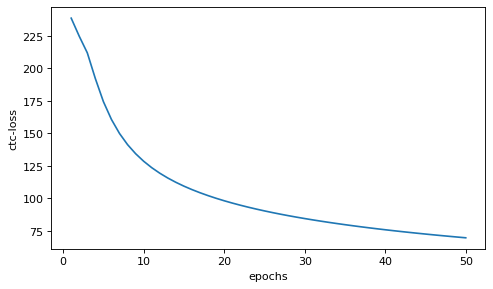

In [11]:
#loss的可视化
x = range(1,51)
plt.figure(figsize=(7,4),dpi=80)
plt.plot(x, loss)
plt.xlabel('epochs') 
plt.ylabel('ctc-loss')

In [18]:
#由于训练后输出为id，所以需要解码为汉字
def decode_ctc(num_result, num2word):
    result = num_result[:, :, :]
    in_len = np.zeros((1), dtype=np.int32)
    in_len[0] = result.shape[1]
    #通过ctc_decode进行解码，使用贪心算法
    r = K.ctc_decode(result, in_len, greedy=True, beam_width=10, top_paths=1)
    r1 = K.get_value(r[0][0])
    r1 = r1[0]
    text = []
    for i in r1:
        text.append(num2word[i])
    return r1, text

In [25]:
batch = data_generator(1, shuffle_list, wav_lst, label_data, vocab)
for i in range(10):
    # 载入训练好的模型，并进行识别
    inputs, outputs = next(batch)
    x = inputs['the_inputs']
    y = inputs['the_labels'][0]
    result = am.model.predict(x, steps=1)
    # 将数字结果转化为文本结果
    result, text = decode_ctc(result, vocab) 
    origin = [vocab[int(i)] for i in y]
    print('数字结果： ', result) #语音识别结果
    print('文本结果：', ''.join(text)) #语音识别结果
    print('原文结果：', ''.join(origin)) #原label
    print('\n')

数字结果：  [ 343  572    2    3    4  839    6    7    8  571  324   11  348   13
  481  363 1749   17   18  458   21 1431   24   25  348  326   48   29]
文本结果： 重位演员有除方圆牟选群远专张起直菌华訾杀欧平林文专中围等
原文结果： 著名演员有成方圆牟炫甫远征张强陈俊华訾莎莉欧阳滨林文增周维等


数字结果：  [  30   31   32  609  321  320   36   37  683  204 1127  973   41  889
 1397  208   25    5  689  279   48  178  286 1059  443   59   73]
文本结果： 可发展职年去色被场也块病单歌喷求文成壮说围九他培分战的
原文结果： 可发展纯棉全色被套印花被单钩边簇绒床罩床围枕套配套件等


数字结果：  [  52  689  195  625  357  687 1166  284   59  175  922  126   59   64
  192  386   67   68 1200  874 2358   72   73   74   11  554  959  320
  327]
文本结果： 驻壮变光母古爱美战是照军战岗市云约听点迎畜外的不远出库去生
原文结果： 驻藏边防某部二连战士赵金站岗时隐隐约约听见营区外的不远处有哭泣声


数字结果：  [  35   80   72   81    4  180    6  582 1036   85 1993   29   86   87
    4  461  310  573  179   92   36  428   95   94   95  354    5  937
  359  100]
文本结果： 全笼外形有司方又老八隆等高达有及从推师三色烧上宽上表成结体状
原文结果： 邛笼外形有四方六棱八棱等高达六七层至十三四层下宽上窄呈阶梯状


数字结果：  [ 620  399  102  103   37  105  687  395   73  321  109   91  110   68
  111  660  2